## James Griffin, coding homework 3 

In [ ]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn


In [2]:
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())



# Question 1

1)  Train a 2-layer linear network with ReLU activations to identify 0s and 1s from MNIST. What did you use as the training set (what percentage)?  How 'wide' was your network?


In [3]:
#selecting the 0s and 1
train_idx = mnist_train.targets <= 1 #only retrieve those with labels less than this value
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

test_idx = mnist_test.targets <= 1 #only retrieve those with labels less than this value
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

#going to shuffle the data just in case there are any sequential dependencies  
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [4]:
#training_percentages / testing percenttages 
training_perc = 1 - (len(test_idx)/(len(test_idx)+len(train_idx)))
testing_perc = len(test_idx)/(len(test_idx)+len(train_idx))

print("this is my training percentage " + str(training_perc))
print("this is my testsing percentage " + str(testing_perc))


this is my training percentage 0.8571428571428572
this is my testsing percentage 0.14285714285714285


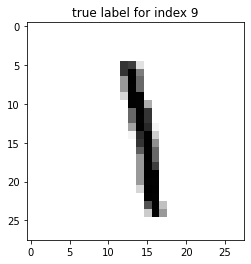

In [5]:
import numpy as np  
import matplotlib.pyplot as plt  

imgs = (test_loader.dataset.data.float()/225).view(len(test_loader.dataset), -1)

idx = 9
true_targets = test_loader.dataset.targets
plt.imshow(1-imgs[idx].view(28,28).numpy(), cmap = 'gray')
plt.title("true label for index " + str(idx))
plt.show()

As we can see, even though  we have 728 pixels in the image (28x28), we do not have 728 peices of information as mosts of the image is just whitespace. We want to essentially reduce the dimmensionality of our image to only, "useful" pixels, so we will set our width to be 20 as we believe there are roughly  20 useful pixels per image 

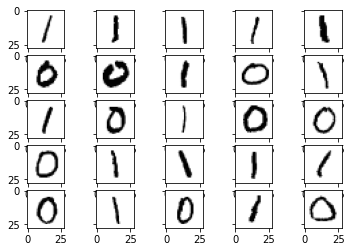

In [82]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-imgs[i].view(28,28).numpy(), cmap="gray")
    ax

In [6]:
def accuracy(outs, targs):
    _, preds = torch.max(outs, dim = 1)
    return(torch.tensor(torch.sum(preds == targs).item()/ len(preds)))

In [7]:
class linear_model_1(nn.Module):
    def __init__(self):
        super().__init__() #inherret everything from nn.module class 
        #reason  for  784 = 28*28 
        #first layer 
        self.linear1 = nn.Linear(784, 20) 
        #second layer 
        self.linear2 = nn.Linear(20,2)

    def forward(self, x):
        #takes the first layer 
        x = x.reshape(-1, 784)
        #call linear 
        x1 = self.linear1(x)
        #activate 
        x1 = F.relu(x1)

        #calls self.linear from layer 1 
        x2 = self.linear2(x1)
        #activates again 
        x2 = F.relu(x2) 
        return x2 


    def train(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs) #cross entropy loss between output and targets 
        #returns that loss function 
        return(loss)

    def validate(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs)
        acc = accuracy(out,targs)
        return({'validate_loss':loss, 'validate_accuracy': acc})

    def validate_epoch_end(self, outs):
      #if we go  all  the way to the  end  of the epoch/batches 
      #look at our loss and acuracy in nice format 
      #

        batch_loss = [x['validate_loss'] for x in outs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_accs = [x['validate_accuracy'] for x in outs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'validate_loss': epoch_loss.item(), 'validate_accuracy' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], validate_loss: {:.4f}, validate_accuracy: {:.4f}".format(epoch, result['validate_loss'], result['validate_accuracy']))


In [8]:
def evaluate(model, test_loader):
    outputs = [model.validate(batch) for batch in test_loader]
    return(model.validate_epoch_end(outputs))
    
    
def fit(epochs, lr, model, train_loader, test_loader, opt_func = torch.optim.SGD):
    history = []
    opt = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        ## Training Phase
        for batch in train_loader:
            loss = model.train(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        ## Validation phase
        result = evaluate(model, test_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [14]:
model_1 = linear_model_1()
history1 = fit(5, 0.01, model_1, train_loader, test_loader)

Epoch [0], validate_loss: 0.4512, validate_accuracy: 0.9306
Epoch [1], validate_loss: 0.3716, validate_accuracy: 0.9686
Epoch [2], validate_loss: 0.3500, validate_accuracy: 0.9897
Epoch [3], validate_loss: 0.3412, validate_accuracy: 0.9911
Epoch [4], validate_loss: 0.3366, validate_accuracy: 0.9950


# Questiotn 2 

2) Now try to train a deeper network (4+ layers) to do the same thing, but this time feel free to use different activation functions.  Can you make the size of each layer smaller, i.e. make it less wide?

In [29]:
class q2_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 40)
        self.linear2 = nn.Linear(40,20)
        self.linear3 = nn.Linear(20,10)
        self.linear4 = nn.Linear(10,2)
    

    def forward (self,x):
        #reshale 
        x = x.reshape(-1, 784)
        #call first layer 
        x1 = self.linear1(x)
        x1 = F.leaky_relu(x1) ##using leaky relu as my activation 

        #second 
        x2 = self.linear2(x1)
        x2 = F.relu(x2)

        #third 
        x3 = self.linear3(x2)
        x3 = F.relu(x3)

        #fourth 
        x4 = self.linear4(x3)
        x4 = F.sigmoid(x4) ## using sigmooid as my last activation because binary 

        return(x4)

    def train(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs)
        return(loss)
    def validate(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs)
        acc = accuracy(out,targs)
        return({'validate_loss':loss, 'validate_accuracy': acc})

    def validate_epoch_end(self, outs):
        batch_loss = [x['validate_loss'] for x in outs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_accs = [x['validate_accuracy'] for x in outs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'validate_loss': epoch_loss.item(), 'validate_accuracy' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], validate_loss: {:.4f}, validate_accuracy: {:.4f}".format(epoch, result['validate_loss'], result['validate_accuracy']))


In [31]:
model2 = q2_model()
history2 = fit(10, 0.01, model2, train_loader, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [0], validate_loss: 0.6877, validate_accuracy: 0.5365
Epoch [1], validate_loss: 0.6843, validate_accuracy: 0.5365
Epoch [2], validate_loss: 0.6796, validate_accuracy: 0.5365
Epoch [3], validate_loss: 0.6717, validate_accuracy: 0.5805
Epoch [4], validate_loss: 0.6566, validate_accuracy: 0.8953
Epoch [5], validate_loss: 0.6292, validate_accuracy: 0.9864
Epoch [6], validate_loss: 0.5775, validate_accuracy: 0.9955
Epoch [7], validate_loss: 0.4860, validate_accuracy: 0.9977
Epoch [8], validate_loss: 0.3993, validate_accuracy: 0.9986
Epoch [9], validate_loss: 0.3565, validate_accuracy: 0.9986


## answer to question 2 

Yeah so it appears that there are way less than 40 significant pixels in the image, because going 784 --> 40, but then we kept just cutting that in half each layer until our last output player had the binary classification 

we also used different activation functions of leaky relu and sigmoid on our first and last layers respectively.

## Question 3

3) Now train a 2-layer convolutional network to do the same thing as the previous 2 problems.  Does this train more efficiently?



In [38]:
class q3_model(nn.Module):
    def __init__(self):
        super().__init__()
        #c1 = torch.tensor([[-1,-1,-1], [1,1,1], [0,0,0]])
        #c2 = torch.tensor([[1,1,1], [0,0,0], [-1,-1,-1]])
        self.conv1 = nn.Conv2d(1,8,3)
        self.conv2 = nn.Conv2d(8,1,3)
        self.linear1 = nn.Linear(8*8*9,2)

    def forward (self,inp):
        intermed1 = self.conv1(inp)
        intermed1 = F.relu(intermed1)
        intermed2 = self.conv2(intermed1)
        intermed2 = F.relu(intermed2)
        #reshape 
        intermed2 = intermed2.view(intermed2.size(0), -1) 
        out = self.linear1(intermed2)
        return(out)

    def train(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs)
        return(loss)

    def validate(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs)
        acc = accuracy(out,targs)
        return({'validate_loss':loss, 'validate_accuracy': acc})

    def validate_epoch_end(self, outs):
        batch_loss = [x['validate_loss'] for x in outs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_accs = [x['validate_accuracy'] for x in outs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'validate_loss': epoch_loss.item(), 'validate_accuracy' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], validate_loss: {:.4f}, validate_accuracy: {:.4f}".format(epoch, result['validate_loss'], result['validate_accuracy']))




In [39]:
model3 = q3_model()
history3 = fit(10, 0.01, model3, train_loader, test_loader)

Epoch [0], validate_loss: 0.6129, validate_accuracy: 0.9873
Epoch [1], validate_loss: 0.0178, validate_accuracy: 0.9973
Epoch [2], validate_loss: 0.0080, validate_accuracy: 0.9986
Epoch [3], validate_loss: 0.0055, validate_accuracy: 0.9986
Epoch [4], validate_loss: 0.0042, validate_accuracy: 0.9991
Epoch [5], validate_loss: 0.0035, validate_accuracy: 0.9995
Epoch [6], validate_loss: 0.0031, validate_accuracy: 0.9995
Epoch [7], validate_loss: 0.0027, validate_accuracy: 0.9995
Epoch [8], validate_loss: 0.0025, validate_accuracy: 0.9995
Epoch [9], validate_loss: 0.0024, validate_accuracy: 0.9995


### answer to question 3 

because the image is convolving through the layers, it does appear to work faster than the original network that we have traied above



## Question 4 

4) Now consider a 'deep' convolutional network, i.e. one with 4+ layers.  How does this change things?

In [80]:
class q4_model(nn.Module):
    def __init__(self):
        super().__init__()
        #c1 = torch.tensor([[-1,-1,-1], [1,1,1], [0,0,0]])
        #c2 = torch.tensor([[1,1,1], [0,0,0], [-1,-1,-1]])
        self.conv1 = nn.Conv2d(1,  8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 8,  3)
        self.conv4 = nn.Conv2d(8,  1,  2)

        self.linear5 = nn.Linear(8*8*16*9,2)

    def forward (self,inp):
        #convolute and activate for each layer 
        intermed1 = self.conv1(inp)
        intermed1 = F.relu(intermed1)
       
        intermed2 = self.conv2(intermed1)
        intermed2 = F.relu(intermed2)
    

        intermed3 = self.conv3(intermed2)
        intermed3 = F.relu(intermed3)


        intermed4 =  self.conv4(intermed3)
        intermed4 = F.relu(intermed2)

        #reshape 
        intermed4 = intermed4.view(intermed4.size(0), -1) 
        #use linear activation which is the dimmensions of the convolutions
        out = self.linear5(intermed4)

        return out

    def train(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs)
        return(loss)

    def validate(self, batch):
        imgs, targs = batch
        out = self(imgs)
        loss = F.cross_entropy(out,targs)
        acc = accuracy(out,targs)
        return({'validate_loss':loss, 'validate_accuracy': acc})

    def validate_epoch_end(self, outs):
        batch_loss = [x['validate_loss'] for x in outs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_accs = [x['validate_accuracy'] for x in outs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'validate_loss': epoch_loss.item(), 'validate_accuracy' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], validate_loss: {:.4f}, validate_accuracy: {:.4f}".format(epoch, result['validate_loss'], result['validate_accuracy']))




In [81]:
model4 = q4_model()
history4 = fit(10, 0.01, model4, train_loader, test_loader)

Epoch [0], validate_loss: 0.0167, validate_accuracy: 0.9986
Epoch [1], validate_loss: 0.0078, validate_accuracy: 0.9982
Epoch [2], validate_loss: 0.0057, validate_accuracy: 0.9986
Epoch [3], validate_loss: 0.0046, validate_accuracy: 0.9986
Epoch [4], validate_loss: 0.0039, validate_accuracy: 0.9991
Epoch [5], validate_loss: 0.0036, validate_accuracy: 0.9991
Epoch [6], validate_loss: 0.0032, validate_accuracy: 0.9991
Epoch [7], validate_loss: 0.0029, validate_accuracy: 0.9995
Epoch [8], validate_loss: 0.0027, validate_accuracy: 0.9995
Epoch [9], validate_loss: 0.0026, validate_accuracy: 0.9995


## answer to question 4 

it takes longer to iterate through, as the computations are way more calculations being done through the convolution, but the accuracy starts really high and stays very high. 